In [5]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
import random
import pal5_util
import pal5_util_MWfit
import MWPotential2014Likelihood
import os, os.path
import re
import glob
import pickle
import csv
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
ro, vo= _REFR0, _REFV0


Populating the interactive namespace from numpy and matplotlib


Jo tested 32 different MW potential models by varying $(f_{d},f_{r},h_{R},h_{Z},r_{s})$. Ignore potential 14.
For each potential model, the MCMC chains have the following values : 
c,vo/220,dist/22.,pmo_parallel,pmo_perp, ln(sigv) and lnlike

In [ ]:
def determine_nburn(filename='../pal5_mcmc/mwpot14-fitsigma-0.dat',
                    threshold=0.1,skip=50,
                    return_nsamples=False):
    """Function to detemrine an appropriate nburn for a given chain"""
    # Load the data
    data= numpy.loadtxt(filename,comments='#',delimiter=',')
    lndata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    # Perform a running diff wrt skip less
    diff= (lndata-numpy.roll(lndata,skip,axis=0))
    diff[:skip]= -100. # Make sure it's not within the first hundred
    maxln= numpy.nanmax(lndata)
    try:
        indx= (numpy.fabs(numpy.median(diff,axis=1)) < threshold)\
                       *((maxln-numpy.nanmax(lndata,axis=1)) < 1.25)
        if maxln > -22.5:
            indx*= numpy.std(lndata,axis=1) < 3.
        if return_nsamples:
            return len(data)-numpy.arange(len(lndata))[indx][0]*nwalkers
        else:
            return numpy.arange(len(lndata))[indx][0]*nwalkers
    except IndexError:
        if return_nsamples: return 100.
        else: return numpy.prod(lndata.shape)-100


nwalkers= 12

#from each MCMC chain file, pick nsamples
nsamples= 1


pot_ind=np.arange(0,32,1)
pot_ind=np.delete(pot_ind,14)

t_age= np.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(vo,ro)

peri_all=[]

import csv
csvdens= open('pot_params.dat','w')
denswriter= csv.writer(csvdens,delimiter=',')

for pindx in pot_ind:
    
    print (pindx)
    # Load this potential
    fn= '../GMC/pal5_mcmc/mwpot14-fitsigma-%i.dat' % pindx
    with open(fn,'rb') as savefile:
        line1= savefile.readline()
    potparams= [float(s) for s in (line1.split(':'.encode())[1].split(','.encode()))]
    #all_potparams[ii]= potparams
    
    denswriter.writerow(potparams)

    tnburn= determine_nburn(fn)
    tdata= numpy.loadtxt(fn,comments='#',delimiter=',')
    tdata= tdata[tnburn::]
    
    print (min(tdata[:,3]),max(tdata[:,3]))
    
    rand_indx=random.sample(range(len(tdata)),nsamples)
    
    peri=[]
    c=1
    
      
    for jj in rand_indx:
            
        tvo= tdata[jj][1]*_REFV0
        pot= MWPotential2014Likelihood.setup_potential(potparams,tdata[jj][0],False,False,
                                                       pal5_util_MWfit._REFR0,tvo)

        # Now compute the stream model for this setup
        dist= tdata[jj][2]*22.
        pmra= -2.296+tdata[jj][3]+tdata[jj][4]
        pmdecpar= 2.257/2.296
        pmdecperp= -2.296/2.257
        pmdec= -2.257+tdata[jj][3]*pmdecpar+tdata[jj][4]*pmdecperp
        vlos= -58.7
        sigv= 0.4*numpy.exp(tdata[jj][5])
        
        
        prog= Orbit([229.018,-0.124,dist,pmra,pmdec,vlos],
                    radec=True,ro=ro,vo=tvo,
                    solarmotion=[-11.1,24.,7.25]).flip()
        
        prog.integrate(t_age,pot)
        peri.append(prog.rperi())
        
    peri_all.append(peri)
    
    
csvdens.flush()
csvdens.close()


In [ ]:
#plot histogram of pericenter

plt.figure(figsize=(10,15))

for ii in range(31):
    plt.subplot(8,4,ii+1)
    plt.hist(peri_all[ii],bins='scott')
    plt.xlabel(r'$r_{peri}$ (kpc)')
    
plt.tight_layout()
plt.show()

In [29]:
#pal5_mcmc_selected_chains_pot{}.dat files were generated on the cluster, they contain 2000 samples 
#from each mcmc chain file

#peri  pmpar c/a  vc sigv 229.018,-0.124,dist,pmra,pmdec,vlos

pot_ind=np.arange(0,32,1)
pot_ind=np.delete(pot_ind,14)

peri_all=[]
pmpar=[]
dist=[]
pot_indx=[]


for jj in range(31):
    dat=numpy.genfromtxt('../GMC/pal5_mcmc/pal5_mcmc_selected_chains_pot{}.dat'.format(pot_ind[jj]),delimiter=',')
    peri_all.append(dat[:,0])
    pmpar.append(dat[:,1])
    dist.append(dat[:,7])
    pot_indx.append(pot_ind[jj])


In [30]:
#determine min and max pericenter, apply pmpar~ -0.4 selection and compare the pericenter distribution
peri_flat_list = [item for sublist in peri_all for item in sublist]

dist_flat_list = [item for sublist in dist for item in sublist]

print (len(peri_flat_list))

pmpar_flat_list = [item for sublist in pmpar for item in sublist]

print (len(pmpar_flat_list))

peri_pmpar_select=[]

for ii in range(len(pmpar_flat_list)):
    if -0.42 < pmpar_flat_list[ii] < -0.38 :
        peri_pmpar_select.append(peri_flat_list[ii])
        
print (len(peri_pmpar_select))

print (min(peri_flat_list),max(peri_flat_list))

62000
62000
150
4.67215711730168 8.01017288118594


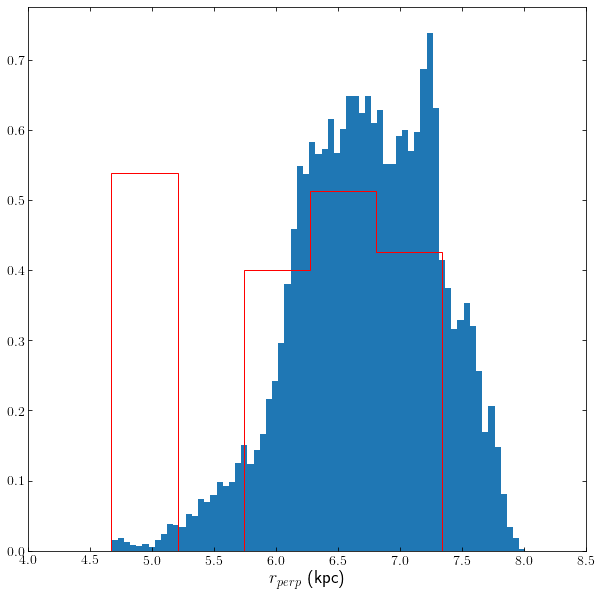

In [31]:
plt.figure(figsize=(10,10))
plt.hist(peri_flat_list,bins='scott',density=True)
plt.hist(peri_pmpar_select,bins='scott',histtype='step',color='red',density=True)
plt.xlim(4.,8.5)
plt.xlabel(r'$r_{perp}$ (kpc)')
#plt.savefig('pal5_mcmc_chains.pdf')
plt.show()

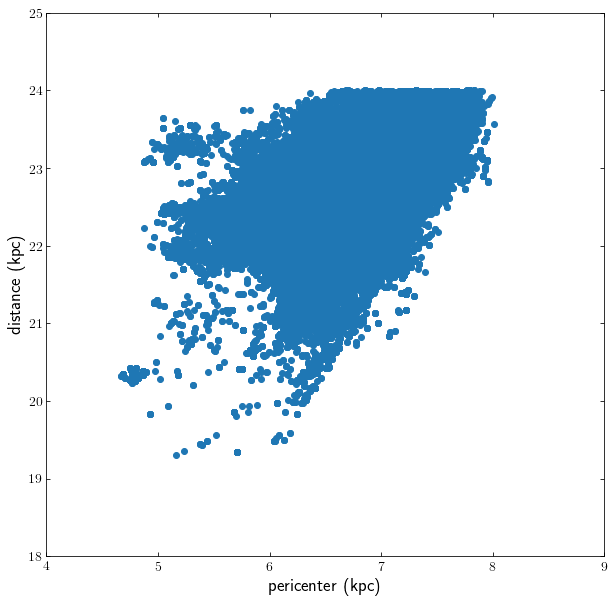

In [33]:
#plot pericenter vs dist

plt.figure()
plt.scatter(peri_flat_list,dist_flat_list)
plt.xlim(4,9)
plt.ylim(18,25)
plt.xlabel('pericenter (kpc)')
plt.ylabel('distance (kpc)')
plt.show()

In [ ]:
#setup a grid of pericenters between min and max and select the corresponding Pal5 orbit and potential

peri_min=4.68
peri_max=8.01

peri_grid=np.linspace(peri_min,peri_max,5)

print (peri_grid)

peri_bin_edge=[]

fo=open('rperi_grid_select.dat','w')
fowriter= csv.writer(fo,delimiter=',')

#define fine bin width to collect a sample of points
for ii in range(len(peri_grid)):
    peri_bin_lo=peri_grid[ii]-0.1
    peri_bin_hi=peri_grid[ii]+0.1
    peri_ind=[]
    
    while len(peri_ind) == 0 :
        
    
        pot_indx=np.random.choice(pot_ind,size=1)[0]
        print ('pot_indx =%i'%pot_indx)

        dat=numpy.genfromtxt('../GMC/pal5_mcmc/pal5_mcmc_selected_chains_pot{}.dat'.format(pot_indx),delimiter=',')
        peri=dat[:,0]
        flat_c=dat[:,2]
        vc=dat[:,3]
        sigv=dat[:,4]
        orbits=dat[:,(5,6,7,8,9,10)]

        for jj in range(len(peri)):
            if peri_bin_lo <= peri[jj] <= peri_bin_hi :
                peri_ind.append(jj)
                
        print (len(peri_ind))
    
            
    orb_ind=np.random.choice(peri_ind,size=1)[0]
    
    out=[pot_indx,peri[orb_ind],flat_c[orb_ind],vc[orb_ind],sigv[orb_ind]]
    out.extend(list(orbits[orb_ind]))
    
    fowriter.writerow(out)
    
fo.flush()
fo.close()


In [1]:
import GMC_util
import pal5_util

#sdf= pal5_util.setup_pal5model()
sdf0=GMC_util.make_nondefault_pal5stream(0)
sdf1=GMC_util.make_nondefault_pal5stream(1)
sdf2=GMC_util.make_nondefault_pal5stream(2)
sdf3=GMC_util.make_nondefault_pal5stream(3)
sdf4=GMC_util.make_nondefault_pal5stream(4)



4.68
5.52
6.4
7.18
7.92


In [2]:
sdf= pal5_util.setup_pal5model()

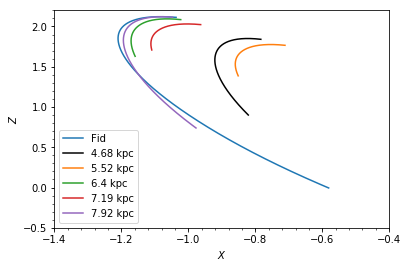

In [6]:
sdf.plotTrack(xrange=[-1.4,-0.4],yrange=[-0.5,2.2],label='Fid')
sdf0.plotTrack(overplot=True,c='k',label='4.68 kpc')
sdf1.plotTrack(overplot=True,label='5.52 kpc')
sdf2.plotTrack(overplot=True,label='6.4 kpc')
sdf3.plotTrack(overplot=True,label='7.19 kpc')
sdf4.plotTrack(overplot=True,label='7.92 kpc')
plt.legend(loc='lower left')
plt.savefig('track.pdf')

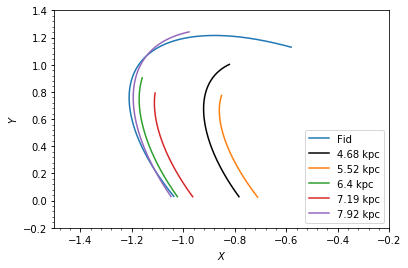

In [8]:
sdf.plotTrack(d1='x',d2='y',xrange=[-1.5,-0.2],yrange=[-0.2,1.4],label='Fid')
sdf0.plotTrack(overplot=True,c='k',d1='x',d2='y',label='4.68 kpc')
sdf1.plotTrack(overplot=True,d1='x',d2='y',label='5.52 kpc')
sdf2.plotTrack(overplot=True,d1='x',d2='y',label='6.4 kpc')
sdf3.plotTrack(overplot=True,d1='x',d2='y',label='7.19 kpc')
sdf4.plotTrack(overplot=True,d1='x',d2='y',label='7.92 kpc')
plt.legend(loc='lower right')
plt.savefig('track_xy.pdf')

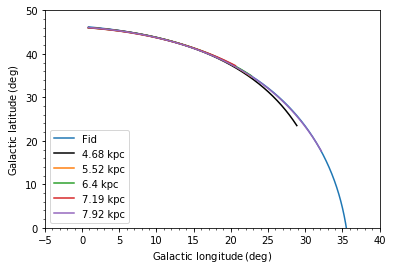

In [13]:
sdf.plotTrack(d1='ll',d2='bb',xrange=[-5,40],yrange=[0,50],label='Fid')
sdf0.plotTrack(overplot=True,c='k',d1='ll',d2='bb',label='4.68 kpc')
sdf1.plotTrack(overplot=True,d1='ll',d2='bb',label='5.52 kpc')
sdf2.plotTrack(overplot=True,d1='ll',d2='bb',label='6.4 kpc')
sdf3.plotTrack(overplot=True,d1='ll',d2='bb',label='7.19 kpc')
sdf4.plotTrack(overplot=True,d1='ll',d2='bb',label='7.92 kpc')
plt.legend(loc='lower left')
plt.savefig('track_lb.pdf')

# set impacts

In [15]:
from simulate_streampepper import parse_times

timpacts=np.array(parse_times('4sampling',5))

print (timpacts)

[ 28.12458454  56.24916908  84.37375362 112.49833816]


In [18]:
sdf_pepper0=GMC_util.make_nondefault_pal5stream(0,timpact=timpacts)

4.68


In [34]:
sdf_pepper3=GMC_util.make_nondefault_pal5stream(3,timpact=timpacts)

7.18


In [19]:
sdf_pepper_fid=pal5_util.setup_pal5model(timpact=timpacts)

In [35]:
#check sign of apars, should be -1 since trailing
print (sdf_pepper0._sigMeanSign,sdf_pepper0._sigMeanSign,sdf_pepper_fid._sigMeanSign)


-1.0 -1.0 -1.0


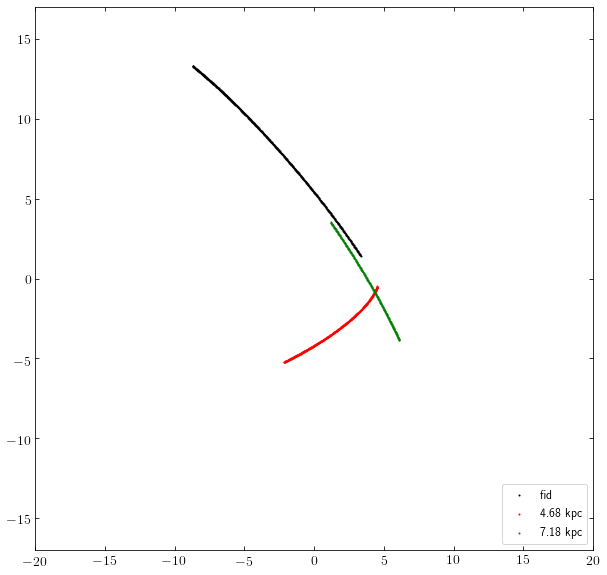

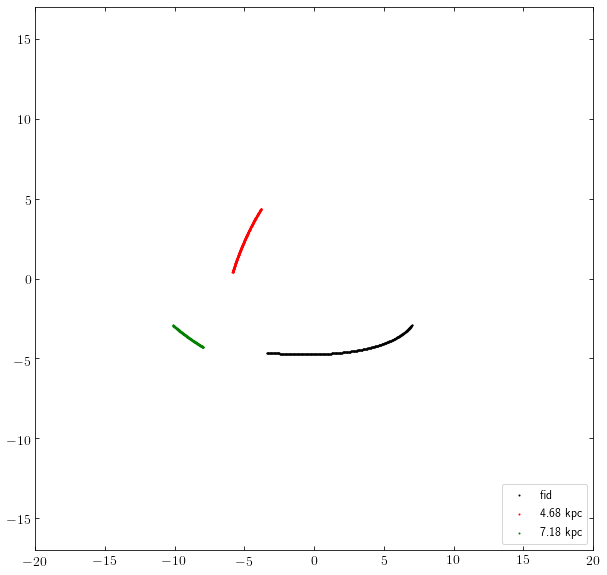

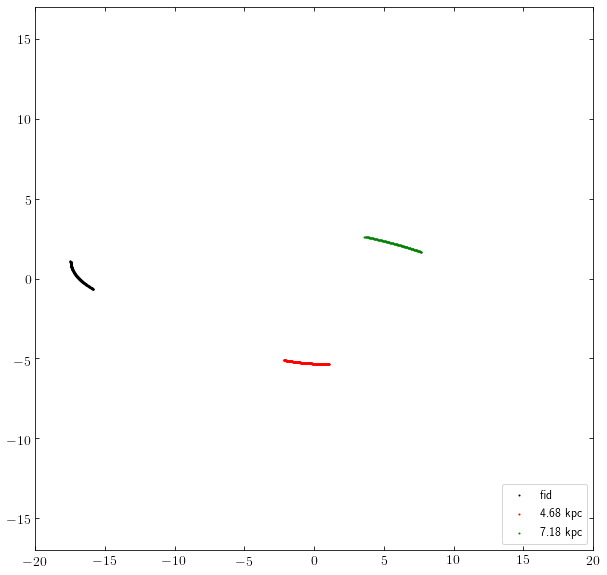

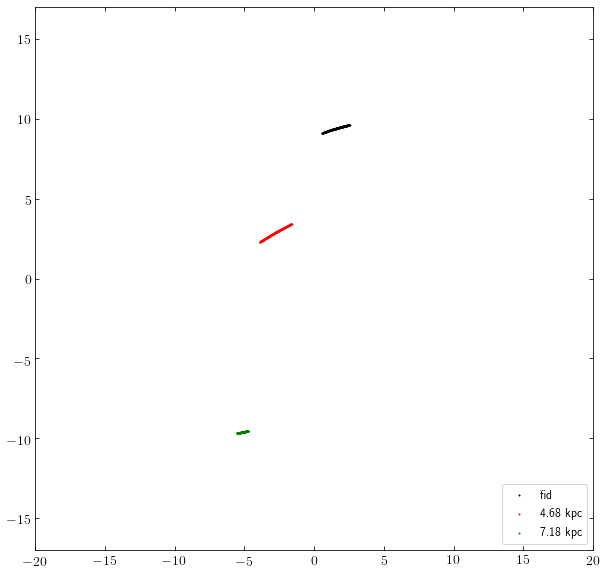

In [37]:
#plot the stream at different timpacts

for kk in range(len(timpacts)):
    
    x=[]
    y=[]
    z=[]
    
    x0=[]
    y0=[]
    z0=[]
    
    x3=[]
    y3=[]
    z3=[]
    
    a= sdf_pepper_fid._sgapdfs_coordtransform[timpacts[kk]]._kick_interpolatedObsTrackXY
    apar_all=sdf_pepper_fid._sgapdfs_coordtransform[timpacts[kk]]._kick_interpolatedThetasTrack
    
    a0= sdf_pepper0._sgapdfs_coordtransform[timpacts[kk]]._kick_interpolatedObsTrackXY
    apar_all0=sdf_pepper0._sgapdfs_coordtransform[timpacts[kk]]._kick_interpolatedThetasTrack
    
    a3= sdf_pepper3._sgapdfs_coordtransform[timpacts[kk]]._kick_interpolatedObsTrackXY
    apar_all3=sdf_pepper3._sgapdfs_coordtransform[timpacts[kk]]._kick_interpolatedThetasTrack
    
    bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
    figsize(10,10)
       
    #at each timpact compute apar_max
    apar_max=sdf.length(tdisrupt=sdf_pepper_fid._tdisrupt-timpacts[kk])*sdf_pepper_fid._length_factor
    apar_max0=sdf0.length(tdisrupt=sdf_pepper0._tdisrupt-timpacts[kk])*sdf_pepper0._length_factor
    apar_max3=sdf3.length(tdisrupt=sdf_pepper3._tdisrupt-timpacts[kk])*sdf_pepper3._length_factor
    
    #considering the stream until apar_max, store xyzvxvyvz 
    for ii in range(len(apar_all)):
        if apar_all[ii] <= apar_max : 
            x.append(a[:,0][ii])
            y.append(a[:,1][ii])
            z.append(a[:,2][ii])
      
    for ii in range(len(apar_all0)):
        if apar_all0[ii] <= apar_max0 : 
            x0.append(a0[:,0][ii])
            y0.append(a0[:,1][ii])
            z0.append(a0[:,2][ii])
            
    for ii in range(len(apar_all3)):
        if apar_all3[ii] <= apar_max3 : 
            x3.append(a3[:,0][ii])
            y3.append(a3[:,1][ii])
            z3.append(a3[:,2][ii])
    
    
    plt.scatter(np.array(x)*ro,np.array(y)*ro,c='k',s=1,label='fid')
    plt.scatter(np.array(x0)*ro,np.array(y0)*ro,c='r',s=1,label='4.68 kpc')
    plt.scatter(np.array(x3)*ro,np.array(y3)*ro,c='g',s=1,label='7.18 kpc')
    plt.xlim(-20.,20.)
    plt.ylim(-17.,17.)
    plt.legend(loc='lower right')
    plt.show()